# GAN (MLP-based)

<div style="display:grid; grid-template-columns:repeat(5, 1fr); gap:5px;">
    <img src="./gan_images/0.png" width="120">
    <img src="./gan_images/20.png" width="120">
    <img src="./gan_images/40.png" width="120">
    <img src="./gan_images/60.png" width="120">
    <img src="./gan_images/80.png" width="120">
    <img src="./gan_images/100.png" width="120">
    <img src="./gan_images/120.png" width="120">
    <img src="./gan_images/140.png" width="120">
    <img src="./gan_images/160.png" width="120">
    <img src="./gan_images/180.png" width="120">
    <img src="./gan_images/200.png" width="120">
    <img src="./gan_images/220.png" width="120">
    <img src="./gan_images/240.png" width="120">
    <img src="./gan_images/260.png" width="120">
    <img src="./gan_images/280.png" width="120">
</div>

# GAN (DCGAN-based)

<div style="display:grid; grid-template-columns:repeat(5, 1fr); gap:5px;">
    <img src="./dcgan_images/0.png" width="120">
    <img src="./dcgan_images/20.png" width="120">
    <img src="./dcgan_images/40.png" width="120">
    <img src="./dcgan_images/60.png" width="120">
    <img src="./dcgan_images/80.png" width="120">
    <img src="./dcgan_images/100.png" width="120">
    <img src="./dcgan_images/120.png" width="120">
    <img src="./dcgan_images/140.png" width="120">
    <img src="./dcgan_images/160.png" width="120">
    <img src="./dcgan_images/180.png" width="120">
    <img src="./dcgan_images/200.png" width="120">
</div>

# Generating new images with GAN

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import my_gan


Using device: mps

Generator (DCGAN) Architecture:
Sequential(
  (0): Linear(in_features=100, out_features=6272, bias=True)
)
Sequential(
  (0): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (1): Upsample(scale_factor=2.0, mode='nearest')
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Upsample(scale_factor=2.0, mode='nearest')
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Tanh()
)
Loaded weights from: ./dc_model


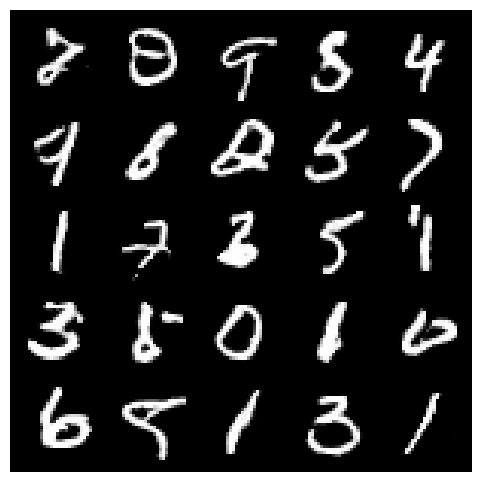

In [3]:
# --- Config ---
LATENT_DIM = 100
USE_CONV_DCGAN = True
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

WEIGHTS_DIR = "./models"
GEN_PATH = os.path.join(WEIGHTS_DIR, "generator.pth")

def _strip_module_prefix(state_dict):
    # Handles DataParallel checkpoints with "module." prefixes
    if not isinstance(state_dict, dict):
        return state_dict
    if not any(k.startswith("module.") for k in state_dict.keys()):
        return state_dict
    return {k.replace("module.", "", 1): v for k, v in state_dict.items()}

def _load_state_dict(path, map_location):
    obj = torch.load(path, map_location=map_location)
    # Allow either plain state_dict or a dict wrapper
    if isinstance(obj, dict) and "state_dict" in obj and isinstance(obj["state_dict"], dict):
        obj = obj["state_dict"]
    if isinstance(obj, dict):
        obj = _strip_module_prefix(obj)
    return obj


# --- Build models ---
G = my_gan.Generator(LATENT_DIM, conv=USE_CONV_DCGAN).to(DEVICE)
# my_gan.sample_images expects generator.device
G.device = DEVICE
    
# --- Load weights if present ---
have_weights = os.path.exists(GEN_PATH)
if have_weights:
    G.load_state_dict(_load_state_dict(GEN_PATH, map_location=DEVICE))
    print(f"Loaded weights from: {WEIGHTS_DIR}")
else:
    print(f"Weights not found in {WEIGHTS_DIR}.")


# --- Inference (generate samples) ---
G.eval()
with torch.no_grad():
    z = torch.randn(25, LATENT_DIM, device=DEVICE)
    samples = G(z)

# [-1, 1] -> [0, 1]
samples = (samples * 0.5 + 0.5).clamp(0, 1)

# Display in notebook
grid = make_grid(samples, nrow=5)
grid_np = grid.detach().cpu().permute(1, 2, 0).numpy()
plt.figure(figsize=(6, 6))
if grid_np.shape[-1] == 1:
    plt.imshow(grid_np.squeeze(-1), cmap="gray")
else:
    plt.imshow(grid_np)
plt.axis("off")
plt.show()

# Interpolating between Latent Vectors

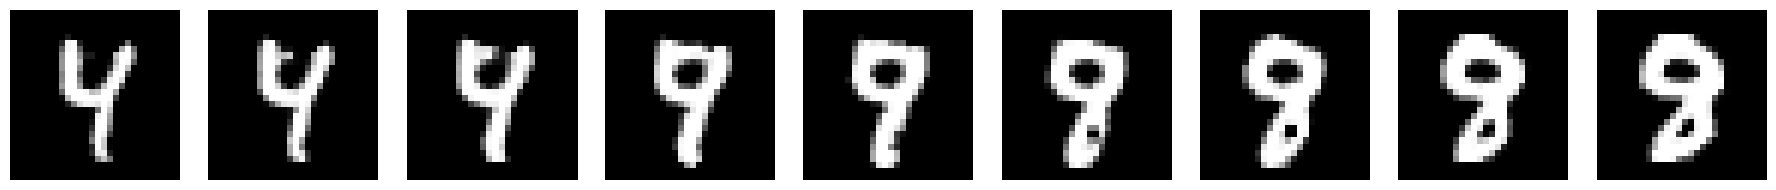

In [6]:
NUM_INTERP_IMAGES = 9

with torch.no_grad():
    z = torch.randn(2, LATENT_DIM, device=DEVICE)
    imgs = G(z)
    imgs_01 = (imgs * 0.5 + 0.5).clamp(0, 1)

alphas = torch.linspace(0, 1, NUM_INTERP_IMAGES, device=DEVICE).unsqueeze(1)  # (9,1)
z_interp = (1 - alphas) * z[0].unsqueeze(0) + alphas * z[1].unsqueeze(0)          # (9,latent)

with torch.no_grad():
    imgs = G(z_interp)
imgs = (imgs * 0.5 + 0.5).clamp(0, 1).detach().cpu()  # (9,1,28,28)

# Display 9 images in a row
fig, axes = plt.subplots(1, NUM_INTERP_IMAGES, figsize=(18, 2))
for i in range(NUM_INTERP_IMAGES):
    axes[i].imshow(imgs[i, 0], cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()